In [ ]:
import os
import shutil
import scipy.io
from keras.utils import get_file, load_img, save_img
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# ! pip install ultralytics
from ultralytics import YOLO


In [ ]:
# Path to images and annotations
path_images = "./101_ObjectCategories/airplanes/"
path_annot = "./Annotations/Airplanes_Side_2/"

path_to_downloaded_file = get_file(
    fname="caltech_101_zipped",
    origin="https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip",
    extract=True,
    archive_format="zip",  # downloaded file format
    cache_dir="/",  # cache and extract in current directory
)
download_base_dir = os.path.dirname(path_to_downloaded_file)

# Extracting tar files found inside main zip file
shutil.unpack_archive(
    os.path.join(download_base_dir, "caltech-101", "101_ObjectCategories.tar.gz"), "."
)
shutil.unpack_archive(
    os.path.join(download_base_dir, "caltech-101", "Annotations.tar"), "."
)



137414764/137414764 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# Prepare paths for images and annotations
image_files = sorted(os.listdir(path_images))
annot_files = sorted(os.listdir(path_annot))

# YOLO-compatible directories
base_dir = os.path.abspath("./yolo_dataset")
train_images_dir = os.path.join(base_dir, "images/train")
val_images_dir = os.path.join(base_dir, "images/val")
test_images_dir = os.path.join(base_dir, "images/test")
train_labels_dir = os.path.join(base_dir, "labels/train")
val_labels_dir = os.path.join(base_dir, "labels/val")
test_labels_dir = os.path.join(base_dir, "labels/test")

# Create directories
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(test_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)
os.makedirs(test_labels_dir, exist_ok=True)

# Resize dimensions
image_size = 224

# Split ratios for train, validation, and test sets
split_ratios = {"train": 0.7, "val": 0.2, "test": 0.1}

# Save images and labels in YOLO format
def save_yolo_data(images_dir, labels_dir, image_files, annot_files, split_ratios):
    total = len(image_files)
    train_end = int(total * split_ratios["train"])
    val_end = train_end + int(total * split_ratios["val"])

    for i, (image_file, annot_file) in enumerate(zip(image_files, annot_files)):
        # Load and resize image
        img_path = os.path.join(path_images, image_file)
        annot_path = os.path.join(path_annot, annot_file)
        image = load_img(img_path).resize((image_size, image_size))

        # Load bounding box and scale it
        annot = scipy.io.loadmat(annot_path)["box_coord"][0]
        orig_w, orig_h = load_img(img_path).size
        x1, y1, x2, y2 = annot[2], annot[0], annot[3], annot[1]
        x1, x2 = x1 / orig_w, x2 / orig_w
        y1, y2 = y1 / orig_h, y2 / orig_h
        cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
        w, h = x2 - x1, y2 - y1

        # Determine train, validation, or test split
        if i < train_end:
            sub_dir = train_images_dir
            label_dir = train_labels_dir
        elif i < val_end:
            sub_dir = val_images_dir
            label_dir = val_labels_dir
        else:
            sub_dir = test_images_dir
            label_dir = test_labels_dir

        # Save resized image and YOLO label
        save_img(os.path.join(sub_dir, f"{i}.jpg"), image)
        with open(os.path.join(label_dir, f"{i}.txt"), "w") as f:
            f.write(f"0 {cx} {cy} {w} {h}\n")


# Save data splits
save_yolo_data(
    train_images_dir,
    train_labels_dir,
    image_files,
    annot_files,
    split_ratios
)

In [ ]:
# Save dataset.yaml
dataset_yaml = f"""
path: {base_dir}
train: images/train
val: images/val
test: images/test
names: ['object']  # Single class
"""
with open(os.path.join(base_dir, "dataset.yaml"), "w") as f:
    f.write(dataset_yaml)

In [ ]:
# Initialize and train YOLO model
model = YOLO("yolov8n.yaml")  # Nano YOLO model
results = model.train(
    data=os.path.join(base_dir, "dataset.yaml"),
    epochs=50,
    imgsz=image_size,
    batch=16,
    workers=2,
    device=0,  # Use GPU
    project="runs",  # Project folder to save results
    name="yolo_training"  # Specific name for the run
)

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/yolo_dataset/dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=0, workers=2, project=runs, name=yolo_training, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=T

100%|██████████| 755k/755k [00:00<00:00, 24.5MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 96.0MB/s]


AMP: checks passed ✅


train: Scanning /content/yolo_dataset/labels/train... 560 images, 0 backgrounds, 0 corrupt: 100%|██████████| 560/560 [00:00<00:00, 1921.22it/s]


train: New cache created: /content/yolo_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/yolo_dataset/labels/val... 160 images, 0 backgrounds, 0 corrupt: 100%|██████████| 160/160 [00:00<00:00, 759.75it/s]

val: New cache created: /content/yolo_dataset/labels/val.cache


Plotting labels to runs/yolo_training/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/yolo_training
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50     0.384G      3.458      3.445      4.189         45        224: 100%|██████████| 35/35 [00:06<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        160     0.0162      0.956     0.0233    0.00557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50     0.348G      3.138      2.547      3.763         42        224: 100%|██████████| 35/35 [00:03<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.13it/s]

                   all        160        160    0.00531          1     0.0831     0.0327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      0.35G      2.965      2.179       3.29         43        224: 100%|██████████| 35/35 [00:03<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.23it/s]

                   all        160        160      0.128     0.0375     0.0742     0.0246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      0.35G      2.727      1.939      3.043         43        224: 100%|██████████| 35/35 [00:05<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.46it/s]

                   all        160        160       0.48      0.491      0.469      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      0.35G      2.423      1.804       2.83         43        224: 100%|██████████| 35/35 [00:03<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.44it/s]

                   all        160        160      0.358      0.531      0.349     0.0907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      0.35G      2.213      1.694      2.658         40        224: 100%|██████████| 35/35 [00:04<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.11it/s]


                   all        160        160      0.677      0.721      0.762      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      0.35G      2.016      1.586      2.505         34        224: 100%|██████████| 35/35 [00:04<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.53it/s]

                   all        160        160      0.524      0.556      0.559      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50     0.348G      1.851      1.492      2.382         33        224: 100%|██████████| 35/35 [00:03<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.60it/s]

                   all        160        160      0.853      0.801      0.891      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50     0.348G      1.714      1.366       2.26         49        224: 100%|██████████| 35/35 [00:04<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.81it/s]

                   all        160        160      0.851      0.856      0.923      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      0.35G      1.691      1.356      2.235         37        224: 100%|██████████| 35/35 [00:03<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.37it/s]

                   all        160        160      0.942      0.944      0.962      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      0.35G      1.585      1.201      2.111         36        224: 100%|██████████| 35/35 [00:03<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.80it/s]

                   all        160        160      0.971      0.925      0.976      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      0.35G      1.514      1.129      2.089         40        224: 100%|██████████| 35/35 [00:05<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.92it/s]

                   all        160        160      0.981      0.969      0.991      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50     0.348G      1.481      1.068      2.019         41        224: 100%|██████████| 35/35 [00:03<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.51it/s]

                   all        160        160      0.988       0.99      0.991      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      0.35G      1.486      1.102      2.016         43        224: 100%|██████████| 35/35 [00:04<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.13it/s]

                   all        160        160      0.993      0.994      0.993      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50     0.348G      1.459      1.086      2.011         32        224: 100%|██████████| 35/35 [00:05<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.32it/s]

                   all        160        160      0.998          1      0.995      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50     0.348G      1.364     0.9696      1.919         38        224: 100%|██████████| 35/35 [00:03<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.64it/s]

                   all        160        160      0.988      0.994      0.995      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50     0.348G      1.365     0.9295      1.899         39        224: 100%|██████████| 35/35 [00:05<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.75it/s]

                   all        160        160          1          1      0.995      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50     0.348G      1.317     0.9245      1.888         36        224: 100%|██████████| 35/35 [00:05<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.88it/s]

                   all        160        160      0.993          1      0.995      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50     0.348G      1.324      0.907      1.861         30        224: 100%|██████████| 35/35 [00:04<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.82it/s]

                   all        160        160      0.999          1      0.995      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      0.35G      1.287     0.8798      1.826         34        224: 100%|██████████| 35/35 [00:05<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.84it/s]

                   all        160        160      0.999          1      0.995      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50     0.348G      1.277     0.8581      1.829         40        224: 100%|██████████| 35/35 [00:03<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.27it/s]

                   all        160        160      0.999          1      0.995      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50     0.348G      1.247     0.8521      1.789         44        224: 100%|██████████| 35/35 [00:07<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.11it/s]

                   all        160        160          1          1      0.995      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50     0.348G      1.257     0.8372      1.786         36        224: 100%|██████████| 35/35 [00:03<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.56it/s]

                   all        160        160      0.997      0.994      0.995      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50     0.348G      1.211     0.8063      1.773         37        224: 100%|██████████| 35/35 [00:05<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.22it/s]

                   all        160        160      0.999          1      0.995      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50     0.348G      1.179     0.7661      1.727         39        224: 100%|██████████| 35/35 [00:03<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.00it/s]

                   all        160        160          1      0.987      0.995      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50     0.348G      1.168       0.75      1.735         41        224: 100%|██████████| 35/35 [00:03<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.58it/s]

                   all        160        160          1          1      0.995      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      0.35G      1.174     0.7483      1.714         38        224: 100%|██████████| 35/35 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.71it/s]

                   all        160        160      0.999          1      0.995      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50     0.348G      1.157     0.7426      1.703         39        224: 100%|██████████| 35/35 [00:03<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.79it/s]

                   all        160        160      0.999          1      0.995       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50     0.348G      1.142     0.7399      1.688         38        224: 100%|██████████| 35/35 [00:03<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.42it/s]

                   all        160        160      0.999          1      0.995       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50     0.348G      1.109     0.7173      1.672         33        224: 100%|██████████| 35/35 [00:05<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.61it/s]

                   all        160        160      0.999          1      0.995      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50     0.348G      1.075     0.6946       1.63         31        224: 100%|██████████| 35/35 [00:03<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.86it/s]

                   all        160        160      0.999          1      0.995      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50     0.348G      1.101     0.7133       1.67         42        224: 100%|██████████| 35/35 [00:04<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.51it/s]

                   all        160        160      0.999          1      0.995       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50     0.348G       1.07     0.6898      1.637         46        224: 100%|██████████| 35/35 [00:04<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.83it/s]

                   all        160        160      0.999          1      0.995      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50     0.348G      1.065     0.6815      1.631         31        224: 100%|██████████| 35/35 [00:03<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.81it/s]

                   all        160        160          1          1      0.995      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50     0.348G      1.043     0.6592      1.614         38        224: 100%|██████████| 35/35 [00:05<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.21it/s]

                   all        160        160      0.999          1      0.995      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50     0.348G      1.014     0.6488      1.579         35        224: 100%|██████████| 35/35 [00:03<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.71it/s]

                   all        160        160      0.999          1      0.995      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50     0.348G      1.019     0.6493      1.601         28        224: 100%|██████████| 35/35 [00:03<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.72it/s]

                   all        160        160      0.999          1      0.995      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50     0.348G     0.9975     0.6296      1.574         33        224: 100%|██████████| 35/35 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.84it/s]

                   all        160        160      0.999          1      0.995      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50     0.348G      1.001     0.6281      1.571         46        224: 100%|██████████| 35/35 [00:05<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.60it/s]

                   all        160        160          1          1      0.995      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50     0.348G     0.9636     0.6092      1.565         30        224: 100%|██████████| 35/35 [00:09<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.38it/s]

                   all        160        160          1          1      0.995      0.889


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50     0.348G     0.9059     0.6981      1.536         16        224: 100%|██████████| 35/35 [00:05<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.41it/s]

                   all        160        160          1          1      0.995      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50     0.348G     0.8267     0.5552      1.457         16        224: 100%|██████████| 35/35 [00:05<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.51it/s]

                   all        160        160          1      0.999      0.995      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50     0.348G     0.7969     0.5299      1.409         16        224: 100%|██████████| 35/35 [00:03<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.78it/s]

                   all        160        160      0.999          1      0.995      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50     0.348G     0.7718     0.5095      1.403         16        224: 100%|██████████| 35/35 [00:03<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.51it/s]

                   all        160        160          1          1      0.995      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50     0.348G     0.7697     0.4947      1.396         16        224: 100%|██████████| 35/35 [00:05<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.62it/s]

                   all        160        160      0.999          1      0.995      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50     0.348G     0.7171      0.464      1.341         16        224: 100%|██████████| 35/35 [00:03<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.48it/s]

                   all        160        160          1          1      0.995      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50     0.348G     0.7188     0.4629      1.362         16        224: 100%|██████████| 35/35 [00:03<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.55it/s]

                   all        160        160          1          1      0.995      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50     0.348G     0.7272     0.4633      1.348         16        224: 100%|██████████| 35/35 [00:04<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.19it/s]

                   all        160        160          1          1      0.995       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50     0.348G     0.6975     0.4479       1.33         16        224: 100%|██████████| 35/35 [00:03<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.94it/s]

                   all        160        160          1          1      0.995      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50     0.348G     0.7052     0.4524      1.329         16        224: 100%|██████████| 35/35 [00:04<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.47it/s]

                   all        160        160          1          1      0.995      0.922



50 epochs completed in 0.086 hours.
Optimizer stripped from runs/yolo_training/weights/last.pt, 6.2MB
Optimizer stripped from runs/yolo_training/weights/best.pt, 6.2MB

Validating runs/yolo_training/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.76it/s]


                   all        160        160          1          1      0.995      0.925
Speed: 0.1ms preprocess, 0.9ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/yolo_training


Available columns in results.csv: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


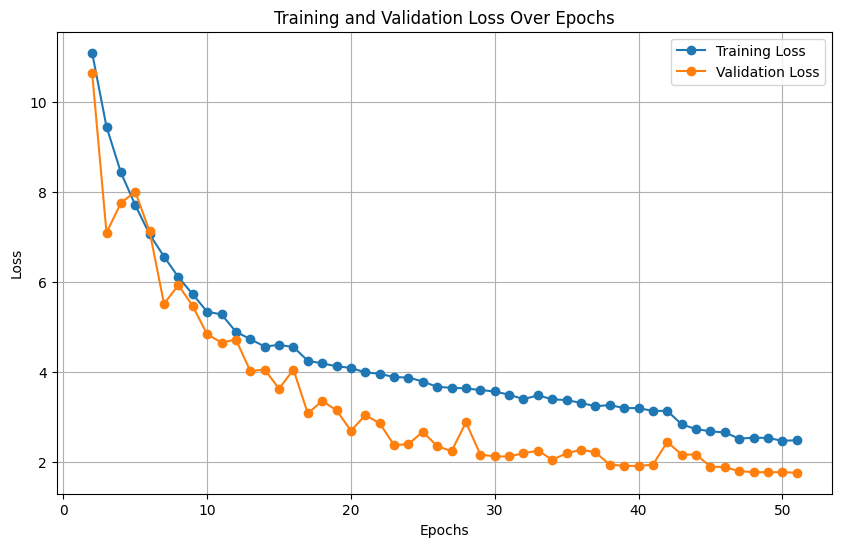

In [ ]:

# Path to the training results CSV file
results_csv_path = os.path.join(results.save_dir, "results.csv")

# Load and inspect training metrics
if os.path.exists(results_csv_path):
    metrics_df = pd.read_csv(results_csv_path)

    print(f"Available columns in results.csv: {list(metrics_df.columns)}")

    # Calculate total training and validation loss
    training_loss = (
        metrics_df["train/box_loss"] + metrics_df["train/cls_loss"] + metrics_df["train/dfl_loss"]
    )
    validation_loss = (
        metrics_df["val/box_loss"] + metrics_df["val/cls_loss"] + metrics_df["val/dfl_loss"]
    )
    epochs = metrics_df["epoch"] + 1

    # Plot the losses
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, training_loss, label="Training Loss", marker="o")
    plt.plot(epochs, validation_loss, label="Validation Loss", marker="o")
    plt.title("Training and Validation Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()
else:
    print(f"Results CSV file not found at {results_csv_path}")

Available columns in results.csv: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


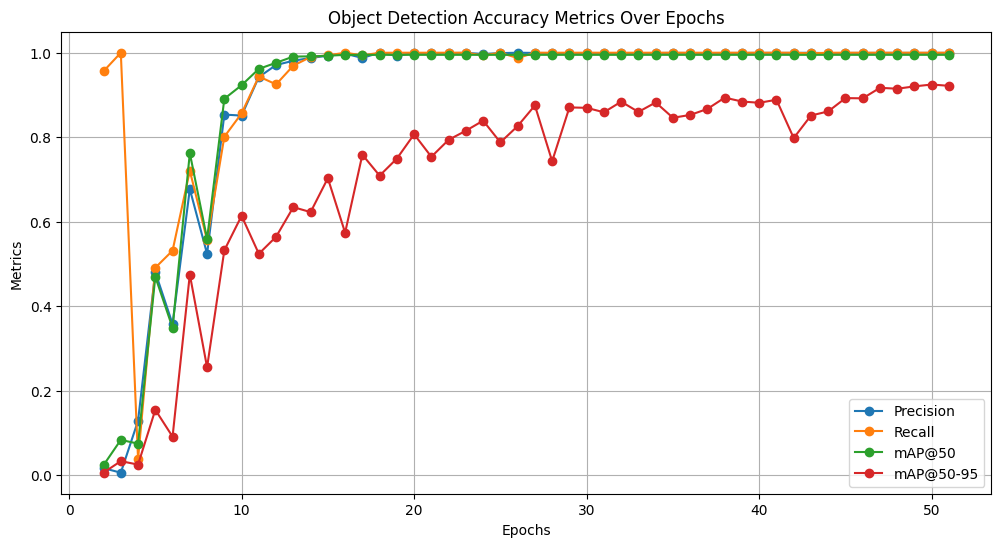

In [ ]:
# Load and inspect training metrics
if os.path.exists(results_csv_path):
    metrics_df = pd.read_csv(results_csv_path)

    print(f"Available columns in results.csv: {list(metrics_df.columns)}")

    # Extract accuracy-related metrics
    precision = metrics_df["metrics/precision(B)"]
    recall = metrics_df["metrics/recall(B)"]
    mAP50 = metrics_df["metrics/mAP50(B)"]  # mAP at IoU=0.5
    mAP50_95 = metrics_df["metrics/mAP50-95(B)"]  # mAP at IoU=0.5:0.95
    epochs = metrics_df["epoch"] + 1

    # Plot the accuracy metrics
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, precision, label="Precision", marker="o")
    plt.plot(epochs, recall, label="Recall", marker="o")
    plt.plot(epochs, mAP50, label="mAP@50", marker="o")
    plt.plot(epochs, mAP50_95, label="mAP@50-95", marker="o")
    plt.title("Object Detection Accuracy Metrics Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.legend()
    plt.grid()
    plt.show()
else:
    print(f"Results CSV file not found at {results_csv_path}")

In [ ]:

def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) for two bounding boxes.
    Each box is represented as (x1, y1, x2, y2).

    Args:
        box1 (tuple): Coordinates of the first box (x1, y1, x2, y2).
        box2 (tuple): Coordinates of the second box (x1, y1, x2, y2).

    Returns:
        float: IoU value.
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Compute intersection area
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

    # Compute union area
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area

    # Avoid division by zero
    if union_area == 0:
        return 0.0

    # Compute IoU
    iou = intersection_area / union_area
    return iou


image 1/1 /content/yolo_dataset/images/test/720.jpg: 224x224 1 object, 13.6ms
Speed: 0.9ms preprocess, 13.6ms inference, 2.3ms postprocess per image at shape (1, 3, 224, 224)


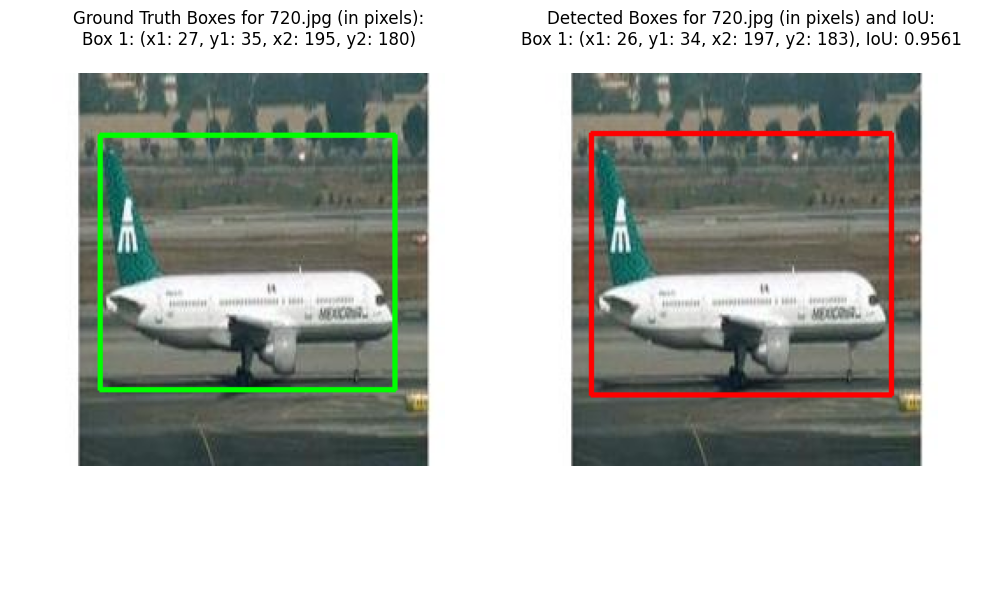


image 1/1 /content/yolo_dataset/images/test/721.jpg: 224x224 1 object, 10.7ms
Speed: 0.9ms preprocess, 10.7ms inference, 1.8ms postprocess per image at shape (1, 3, 224, 224)


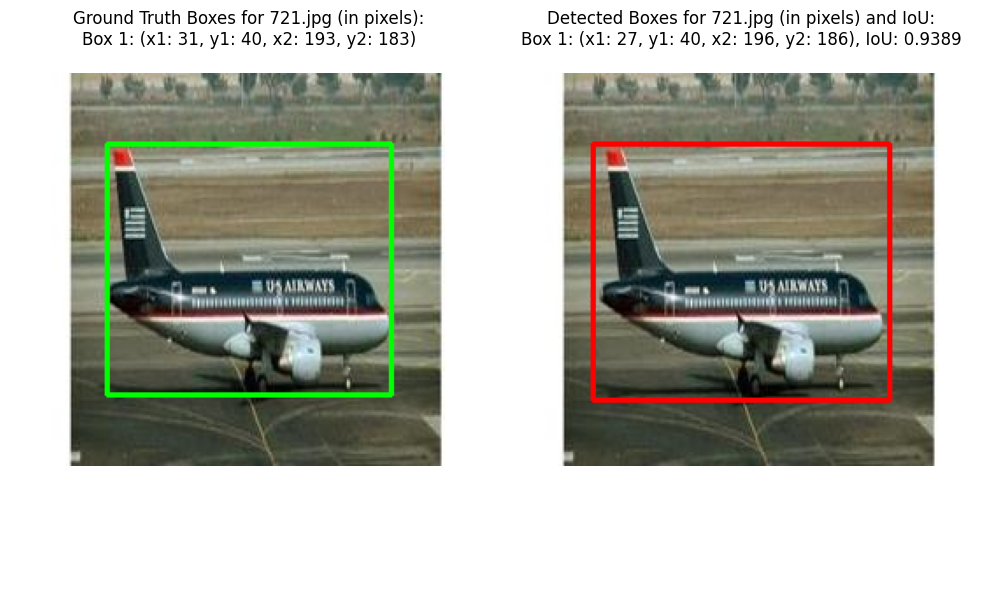


image 1/1 /content/yolo_dataset/images/test/722.jpg: 224x224 1 object, 11.2ms
Speed: 0.8ms preprocess, 11.2ms inference, 1.7ms postprocess per image at shape (1, 3, 224, 224)


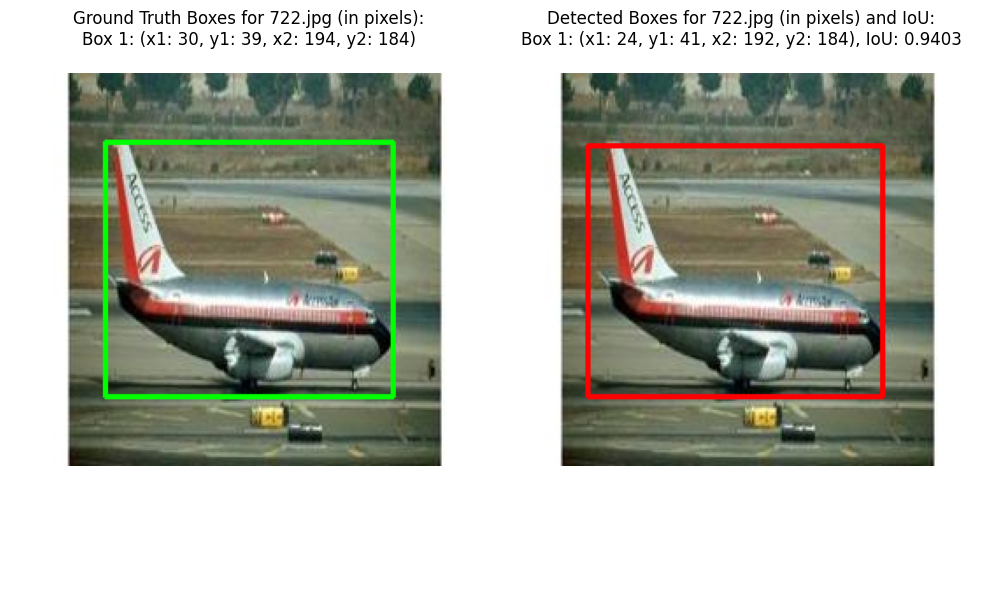


image 1/1 /content/yolo_dataset/images/test/723.jpg: 224x224 1 object, 10.9ms
Speed: 0.9ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 224, 224)


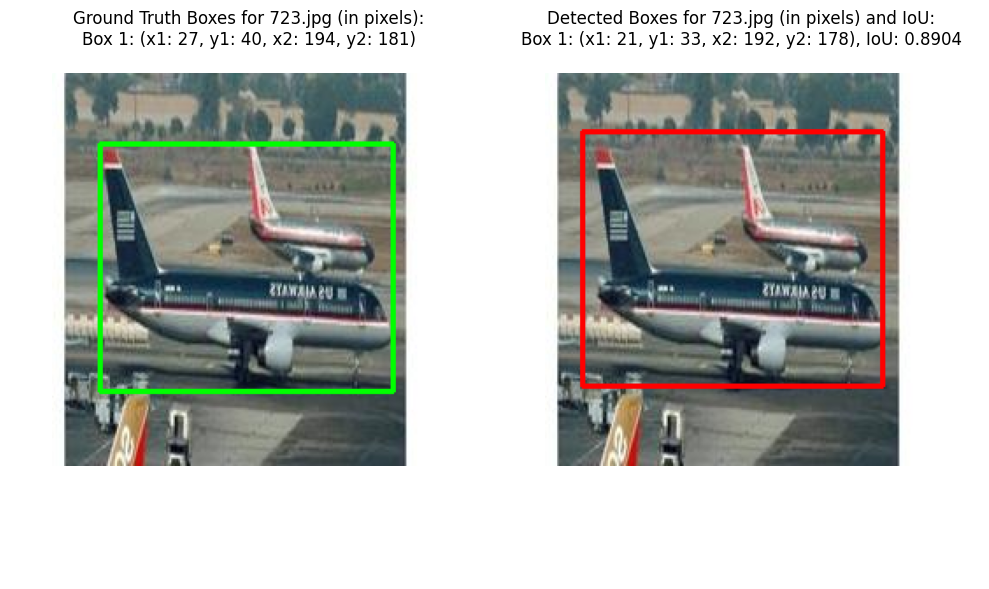


image 1/1 /content/yolo_dataset/images/test/724.jpg: 224x224 1 object, 11.0ms
Speed: 0.7ms preprocess, 11.0ms inference, 1.8ms postprocess per image at shape (1, 3, 224, 224)


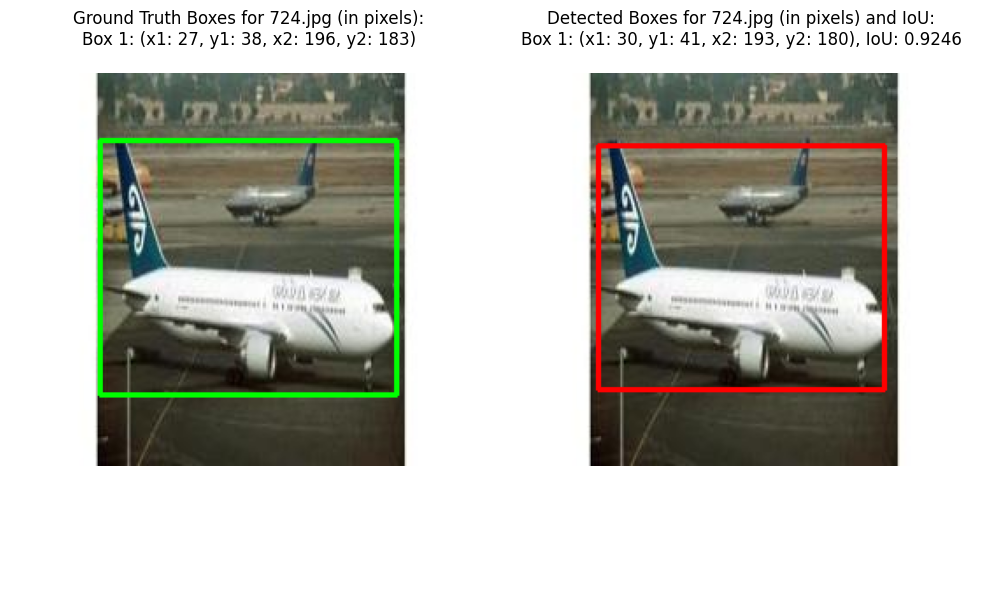

In [ ]:
def detect_objects_with_comparison(model, image_path, label_path, image_name):
    """
    Perform detection and display predicted and target images side by side
    with bounding box details and IoU displayed below each image.

    Args:
        model: YOLO model instance.
        image_path (str): Path to the test image.
        label_path (str): Path to the ground-truth label file.
        image_name (str): Name of the image being processed (for display purposes).
    """
    # Load the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for plotting
    h, w, _ = image.shape

    # Load ground-truth bounding boxes
    with open(label_path, "r") as f:
        labels = f.readlines()
    ground_truth_boxes = []
    for label in labels:
        _, cx, cy, box_w, box_h = map(float, label.strip().split())
        x1 = int((cx - box_w / 2) * w)
        y1 = int((cy - box_h / 2) * h)
        x2 = int((cx + box_w / 2) * w)
        y2 = int((cy + box_h / 2) * h)
        ground_truth_boxes.append((x1, y1, x2, y2))

    # Perform inference and get detected boxes
    results = model.predict(source=image_path, save=False, imgsz=(w, h))
    detected_boxes = []
    if hasattr(results[0], "boxes"):
        detected_boxes = results[0].boxes.xyxy.cpu().numpy()

    # Create copies of the image for drawing boxes
    target_image = image_rgb.copy()
    predicted_image = image_rgb.copy()

    # Draw ground-truth boxes in green
    for x1, y1, x2, y2 in ground_truth_boxes:
        cv2.rectangle(target_image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green box

    # Draw detected boxes in blue
    for box in detected_boxes:
        x1, y1, x2, y2 = map(int, box[:4])
        cv2.rectangle(predicted_image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue box

    # Prepare text for bounding box details and IoU
    ground_truth_text = f"Ground Truth Boxes for {image_name} (in pixels):\n"
    for i, (x1, y1, x2, y2) in enumerate(ground_truth_boxes):
        ground_truth_text += f"Box {i+1}: (x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2})\n"

    detected_text = f"Detected Boxes for {image_name} (in pixels) and IoU:\n"
    for i, box in enumerate(detected_boxes):
        x1, y1, x2, y2 = map(int, box[:4])
        detected_box_tuple = (x1, y1, x2, y2)

        # Calculate IoU for the detected box with each ground-truth box
        iou_values = [calculate_iou(gt_box, detected_box_tuple) for gt_box in ground_truth_boxes]
        best_iou = max(iou_values) if iou_values else 0.0

        detected_text += f"Box {i+1}: (x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}), IoU: {best_iou:.4f}\n"

    # Plot the images side by side
    fig, axes = plt.subplots(2, 2, figsize=(10, 6), gridspec_kw={'height_ratios': [4, 1]})

    # Display ground truth image
    axes[0, 0].imshow(target_image)
    axes[0, 0].set_title(ground_truth_text)
    axes[0, 0].axis("off")
    axes[1, 0].axis("off")

    # Display predicted image
    axes[0, 1].imshow(predicted_image)
    axes[0, 1].set_title(detected_text)
    axes[0, 1].axis("off")
    axes[1, 1].axis("off")

    plt.tight_layout()
    plt.show()


# Loop through images 720.jpg to 730.jpg
for i in range(720, 725):
    test_image_path = os.path.join(test_images_dir, f"{i}.jpg")
    test_label_path = os.path.join(test_labels_dir, f"{i}.txt")

    if os.path.exists(test_image_path) and os.path.exists(test_label_path):
        detect_objects_with_comparison(model, test_image_path, test_label_path, f"{i}.jpg")
    else:
        print(f"Image or label file not found for {i}.jpg")


In [ ]:
def evaluate_model_iou(model, test_images_dir, test_labels_dir):
    """
    Evaluate the model's performance by calculating IoU for the test dataset.

    Args:
        model: YOLO model instance.
        test_images_dir (str): Directory containing test images.
        test_labels_dir (str): Directory containing ground-truth labels.

    Returns:
        list: List of IoU values for all test images.
    """
    iou_scores = []
    test_image_files = sorted(os.listdir(test_images_dir))
    test_label_files = sorted(os.listdir(test_labels_dir))

    for image_file, label_file in zip(test_image_files, test_label_files):
        image_path = os.path.join(test_images_dir, image_file)
        label_path = os.path.join(test_labels_dir, label_file)

        # Load ground-truth bounding box
        with open(label_path, "r") as f:
            labels = f.readlines()
        ground_truth_boxes = []
        for label in labels:
            _, cx, cy, box_w, box_h = map(float, label.strip().split())
            w, h, _ = cv2.imread(image_path).shape
            x1 = int((cx - box_w / 2) * w)
            y1 = int((cy - box_h / 2) * h)
            x2 = int((cx + box_w / 2) * w)
            y2 = int((cy + box_h / 2) * h)
            ground_truth_boxes.append((x1, y1, x2, y2))

        # Perform inference and get detected boxes
        results_performance = model.predict(source=image_path, save=False, imgsz=(w, h))
        detected_boxes = []
        if hasattr(results_performance[0], "boxes"):
            detected_boxes = results_performance[0].boxes.xyxy.cpu().numpy()

        # Compare ground-truth and detected boxes
        for gt_box in ground_truth_boxes:
            best_iou = 0
            for detected_box in detected_boxes:
                x1, y1, x2, y2 = map(int, detected_box[:4])
                detected_box_tuple = (x1, y1, x2, y2)
                iou = calculate_iou(gt_box, detected_box_tuple)
                best_iou = max(best_iou, iou)
            iou_scores.append(best_iou)

    return iou_scores


# Evaluate IoU for the test set
iou_scores = evaluate_model_iou(model, test_images_dir, test_labels_dir)

# Calculate mean IoU
mean_iou = np.mean(iou_scores)
print(f"\n \033[94m \033[1m Mean IoU for the test set: {mean_iou:.4f} \033[1m \033[94m")



image 1/1 /content/yolo_dataset/images/test/720.jpg: 224x224 1 object, 33.9ms
Speed: 0.8ms preprocess, 33.9ms inference, 1.9ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /content/yolo_dataset/images/test/721.jpg: 224x224 1 object, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /content/yolo_dataset/images/test/722.jpg: 224x224 1 object, 16.3ms
Speed: 0.5ms preprocess, 16.3ms inference, 12.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /content/yolo_dataset/images/test/723.jpg: 224x224 1 object, 9.2ms
Speed: 0.5ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /content/yolo_dataset/images/test/724.jpg: 224x224 1 object, 8.5ms
Speed: 0.5ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /content/yolo_dataset/images/test/725.jpg: 224x224 1 object, 8.5ms
Speed: 0.5ms preprocess, 8.5ms inference, 1.6